# Making a new domain: `CStarSpecBuilder`

This notebook demonstrates how to create a new domain and run a ROMS simulation using C-SON Forge.


## Setup

First, import the necessary modules and define the domain configuration parameters.


In [2]:
%load_ext autoreload
%autoreload 2

import cson_forge
import cstar.execution.handler as handler
import time
from datetime import datetime 

grid_name = "NEP-4th_deg"
model_name = "cson_roms-marbl_v0.1"
start_time = datetime(2012, 1, 1)
end_time = datetime(2012, 1, 2) 

grid_kwargs = dict[str, float](
    nx=208,
    ny=192,
    size_x=1460*3,
    size_y=2220*3,
    center_lon=-155,
    center_lat=42,
    rot=-90,
    N=10,  # number of vertical levels
    theta_s=6.0,  # surface control parameter
    theta_b=3.0,  # bottom control parameter
    hc=250.0,  # critical depth
)

boundaries={
        "south": True,
        "east": False,
        "north": True,
        "west": True, 
    }

partitioning = {
    "n_procs_x": 16, # number of partitions in xi (x) 
    "n_procs_y": 8, # number of partitions in eta (y) 
}


ERROR 1: PROJ: proj_create_from_database: Open of /anvil/projects/x-ees250129/x-awyatt1/.conda-env/share/proj failed


## Initialize CstarSpecBuilder

Create a `CstarSpecBuilder` instance with the domain configuration. This initializes the PRECONFIG stage, creating the grid object and blueprint structure.


In [3]:
ocn = cson_forge.CstarSpecBuilder(
    description="Test NEP",
    model_name=model_name,
    grid_name=grid_name,
    grid_kwargs=grid_kwargs,
    open_boundaries=boundaries,    
    start_time=start_time,
    end_time=end_time,
    partitioning=partitioning,
)


### Visualize the grid

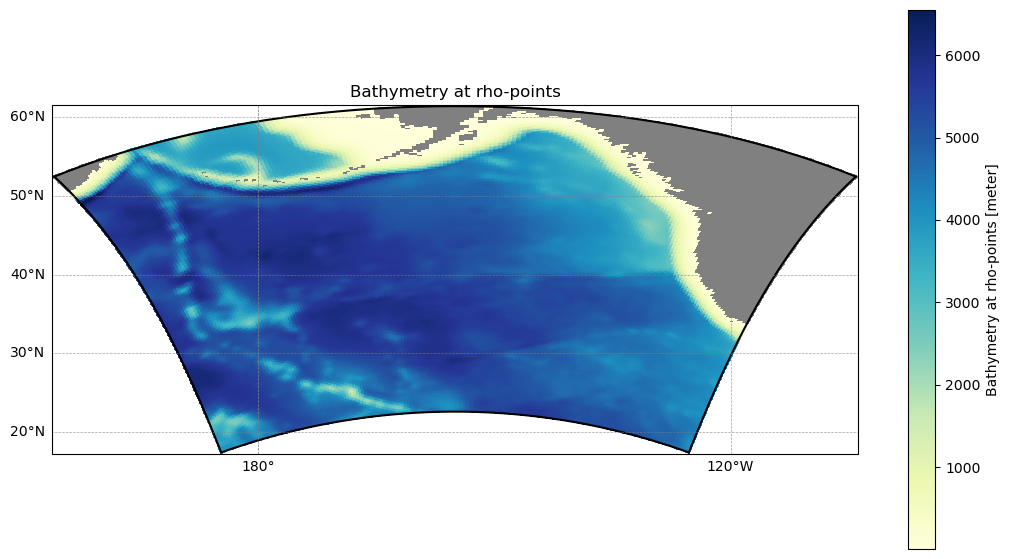

In [4]:
ocn.grid.plot()

## Prepare Source Data

Ensure that all required source datasets (GLORYS, UNIFIED, SRTM15, etc.) are staged locally. This downloads and prepares the data needed for input generation.


In [6]:
# ensure that source data is staged locally
ocn.ensure_source_data(clobber=True)

INFO - 2026-02-12T14:05:45Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


⬇️  Downloading GLORYS_REGIONAL for 2012-01-01 → cmems_mod_glo_phy_my_0.083deg_P1D-m_REGIONAL_NEP-4th_deg_20120101.nc
Copernicus Marine username:

Copernicus Marine username:

  awyatt2


Copernicus Marine password:

  ········


INFO - 2026-02-12T14:05:52Z - Selected dataset version: "202311"
INFO - 2026-02-12T14:05:52Z - Selected dataset part: "default"


  0%|          | 0/59 [00:00<?, ?it/s]

[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connectio

⬇️  Downloading GLORYS_REGIONAL for 2012-01-02 → cmems_mod_glo_phy_my_0.083deg_P1D-m_REGIONAL_NEP-4th_deg_20120102.nc
Copernicus Marine username:

  awyatt2


Copernicus Marine password:

  ········


INFO - 2026-02-12T14:07:15Z - Selected dataset version: "202311"
INFO - 2026-02-12T14:07:15Z - Selected dataset part: "default"


  0%|          | 0/59 [00:00<?, ?it/s]

[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connection pool is full, discarding connection: s3.waw3-1.cloudferro.com. Connection pool size: 10
[WARNING] Connectio

✔️  TPXO dataset verified at: /anvil/projects/x-ees250129/cson-forge-data/source-data/TPXO/TPXO10.v2
⚠️  Clobber=True: removing existing BGC file BGCdataset.nc
⬇️  Downloading BGC dataset → /anvil/projects/x-ees250129/cson-forge-data/source-data/UNIFIED_BGC/BGCdataset.nc


Downloading...
From (original): https://drive.google.com/uc?id=1wUNwVeJsd6yM7o-5kCx-vM3wGwlnGSiq
From (redirected): https://drive.google.com/uc?id=1wUNwVeJsd6yM7o-5kCx-vM3wGwlnGSiq&confirm=t&uuid=b3943008-602d-4ddd-8bba-f20afdca2d60
To: /anvil/projects/x-ees250129/cson-forge-data/source-data/UNIFIED_BGC/BGCdataset.nc
100%|██████████| 21.4G/21.4G [02:39<00:00, 134MB/s]  


## Generate Input Files

Generate all model input files (grid, initial conditions, forcing) from the source data. This completes the POSTCONFIG stage and updates the blueprint with actual file paths.

The system will look for an existing blueprint and, if a match is found, it will use that data unless the user sets `clobber=True` to force re-generating the data. 


In [7]:
# prepare model input
ocn.generate_inputs(clobber=True) # setting clobber=True will overwrite existing files



▶️  [1/8] Writing ROMS grid...

▶️  [2/8] Generating initial conditions...
[########################################] | 100% Completed | 34.58 ss

▶️  [3/8] Generating surface forcing...
[########################################] | 100% Completed | 6.76 sms

▶️  [4/8] Generating surface forcing...
[########################################] | 100% Completed | 102.84 ms

▶️  [5/8] Generating boundary forcing...


[WARNING] The northern boundary is divided by land. It would be safer (but slower and more memory-intensive) to use `apply_2d_horizontal_fill = True`.
[WARNING] The western boundary is divided by land. It would be safer (but slower and more memory-intensive) to use `apply_2d_horizontal_fill = True`.


[########################################] | 100% Completed | 934.64 ms

▶️  [6/8] Generating boundary forcing...
[########################################] | 100% Completed | 16.97 s

▶️  [7/8] Generating tidal forcing...
[########################################] | 100% Completed | 6.86 sms

▶️  [8/8] Generating river forcing...

✅ All input files generated.



RomsMarblBlueprint(name='cson_roms-marbl_v0.1_NEP-4th_deg', description='Test NEP', application=<Application.ROMS_MARBL: 'roms_marbl'>, state=<BlueprintState.NotSet: 'notset'>, valid_start_date=datetime.datetime(2012, 1, 1, 0, 0), valid_end_date=datetime.datetime(2012, 1, 2, 0, 0), code={'roms': {'documentation': '', 'locked': False, 'location': 'https://github.com/CWorthy-ocean/ucla-roms.git', 'commit': '84f4ee7886e9ee4c33b3248b35c955551f3b9c06', 'branch': '', 'filter': None}, 'run_time': {'documentation': '', 'locked': False, 'location': 'placeholder://run_time', 'commit': '', 'branch': 'main', 'filter': None}, 'compile_time': {'documentation': '', 'locked': False, 'location': 'placeholder://compile_time', 'commit': '', 'branch': 'main', 'filter': None}, 'marbl': {'documentation': '', 'locked': False, 'location': 'https://github.com/marbl-ecosys/MARBL.git', 'commit': 'marbl0.45.0', 'branch': '', 'filter': None}}, initial_conditions={'documentation': '', 'locked': False, 'data': [{'lo

## Access Generated Input Datasets

Input datasets are available on the `datasets` attribute of the `CstarSpecBuilder` after `generate_inputs()` has completed. The `datasets` dictionary only contains keys for fields that exist in the blueprint and have been successfully generated.

**Note:** Datasets are only available after `generate_inputs()` has run and populated the blueprint with actual file paths. If a key doesn't exist, it means that field wasn't generated or isn't in the blueprint.

In [8]:
for key in ocn.datasets.keys():
    print("-"*100)
    print(key)
    print(ocn.datasets[key])

----------------------------------------------------------------------------------------------------
grid
<xarray.Dataset> Size: 4MB
Dimensions:       (eta_rho: 194, xi_rho: 210, xi_u: 209, eta_v: 193,
                   eta_coarse: 98, xi_coarse: 106, s_rho: 10, s_w: 11)
Coordinates:
    lat_rho       (eta_rho, xi_rho) float64 326kB ...
    lon_rho       (eta_rho, xi_rho) float64 326kB ...
    lat_u         (eta_rho, xi_u) float64 324kB ...
    lon_u         (eta_rho, xi_u) float64 324kB ...
    lat_v         (eta_v, xi_rho) float64 324kB ...
    lon_v         (eta_v, xi_rho) float64 324kB ...
    lat_coarse    (eta_coarse, xi_coarse) float64 83kB ...
    lon_coarse    (eta_coarse, xi_coarse) float64 83kB ...
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/15)
    angle         (eta_rho, xi_rho) float64 326kB ...
    f             (eta_rho, xi_rho) float64 326kB ...
    pm            (e

## Configure Build

Render the Jinja2 templates to generate compile-time and run-time configuration files (`.opt` files, `roms.in`, etc.). This prepares the BUILD stage.


In [10]:
# configure and build the model
ocn.configure_build(compile_time_settings={}, run_time_settings={})


ROMSSimulation(
name = cson_roms-marbl_v0.1_NEP-4th_deg,
directory = /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_NEP-4th_deg_20120101-20120102,
start_date = 2012-01-01 00:00:00,
end_date = 2012-01-02 00:00:00,
valid_start_date = 2012-01-01 00:00:00,
valid_end_date = 2012-01-02 00:00:00,
discretization = ROMSDiscretization(time_step = 60, n_procs_x = 16, n_procs_y = 8),
codebase = <ROMSExternalCodeBase instance>,
runtime_code = <AdditionalCode instance>,
compile_time_code = <AdditionalCode instance>
model_grid = <ROMSModelGrid instance>,
initial_conditions = <ROMSInitialConditions instance>,
tidal_forcing = <ROMSTidalForcing instance>,
river_forcing = <ROMSRiverForcing instance>,
surface_forcing = <list of 2 ROMSSurfaceForcing instances>,
boundary_forcing = <list of 2 ROMSBoundaryForcing instances>,
)

## Build Model Executable

Compile the ROMS/MARBL model source code to create the executable. This uses the C-Star build system to compile the model with the specified configuration.


In [12]:
ocn.build()


[INFO] 🛠️ Configuring ROMSSimulation
[INFO] 🔧 Setting up ROMSExternalCodeBase...
[INFO] 🔧 Setting up MARBLExternalCodeBase...
[INFO] 📦 Fetching compile-time code...
[INFO] 📦 Fetching runtime code... 
[INFO] 📦 Fetching input datasets...


ROMSSimulation(
name = cson_roms-marbl_v0.1_test-tiny-abigale,
directory = /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_test-tiny-abigale_20120101-20120102,
start_date = 2012-01-01 00:00:00,
end_date = 2012-01-02 00:00:00,
valid_start_date = 2012-01-01 00:00:00,
valid_end_date = 2012-01-02 00:00:00,
discretization = ROMSDiscretization(time_step = 1800, n_procs_x = 1, n_procs_y = 1),
codebase = <ROMSExternalCodeBase instance>,
runtime_code = <AdditionalCode instance>,
compile_time_code = <AdditionalCode instance>
model_grid = <ROMSModelGrid instance>,
initial_conditions = <ROMSInitialConditions instance>,
tidal_forcing = <ROMSTidalForcing instance>,
river_forcing = <ROMSRiverForcing instance>,
surface_forcing = <list of 2 ROMSSurfaceForcing instances>,
boundary_forcing = <list of 2 ROMSBoundaryForcing instances>,
)

## Pre-Run Setup

Perform pre-run operations, including partitioning input files for parallel execution if needed.


In [13]:
# perform partitioning
ocn.pre_run()


[INFO] Partitioning /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_test-tiny-abigale_20120101-20120102/input/input_datasets/cson_roms-marbl_v0.1_test-tiny-abigale_grid.nc into (1,1)
[INFO] Partitioning /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_test-tiny-abigale_20120101-20120102/input/input_datasets/cson_roms-marbl_v0.1_test-tiny-abigale_initial_conditions.nc into (1,1)
[INFO] Partitioning /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_test-tiny-abigale_20120101-20120102/input/input_datasets/cson_roms-marbl_v0.1_test-tiny-abigale_tidal.nc into (1,1)
[INFO] Partitioning /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_test-tiny-abigale_20120101-20120102/input/input_datasets/cson_roms-marbl_v0.1_test-tiny-abigale_river.nc into (1,1)
[INFO] Partitioning /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_test-tiny-abigale_20120101-20120102/input/input_datasets/cson_roms-marbl_v0.1_test-tiny-abigale_boundary-physics_201201

## Run Model Simulation

Execute the ROMS model simulation. This runs the model with the configured inputs and settings.


In [14]:
# run the model
exec_handler = ocn.run()
print(exec_handler)


[INFO] Running srun -n 1 /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_test-tiny-abigale_20120101-20120102/input/compile_time_code/roms /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_test-tiny-abigale_20120101-20120102/input/runtime_code/cson_roms-marbl_v0.1_test-tiny-abigale.in
LocalProcess
------------
Commands: srun -n 1 /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_test-tiny-abigale_20120101-20120102/input/compile_time_code/roms /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_test-tiny-abigale_20120101-20120102/input/runtime_code/cson_roms-marbl_v0.1_test-tiny-abigale.in
Run path: /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_test-tiny-abigale_20120101-20120102/output
Output file: /anvil/scratch/x-awyatt1/cson-forge-run/cson_roms-marbl_v0.1_test-tiny-abigale_20120101-20120102/logs/cson_roms-marbl_v0-1_test-tiny-abigale.out
Status: running


In [15]:
%%time

while not handler.ExecutionStatus.is_terminal(exec_handler.status):
    print("...", end="", flush=True)
    time.sleep(30)

if exec_handler.status == handler.ExecutionStatus.COMPLETED:
    print()
    print("Completed")
    ocn.post_run()
else:
    raise Exception("Model run failed")

CPU times: user 347 μs, sys: 4 μs, total: 351 μs
Wall time: 262 μs


Exception: Model run failed

## Visualize Model Output

After the model run completes, you can load and visualize the output data. The code below:

1. **Finds output files**: Uses `glob` to locate all BGC (biogeochemical) output files in the `JOINED_OUTPUT` directory
2. **Opens the dataset**: Uses `xarray.open_mfdataset()` to open multiple NetCDF files as a single dataset
3. **Applies land mask**: Masks out land points using the grid's `mask_rho` variable
4. **Plots a variable**: Creates a plot of dissolved inorganic carbon (DIC) at the first time step and bottom vertical level (`s_rho=-1`)

The `JOINED_OUTPUT` directory contains the spatially-joined output files created by `post_run()`, which combine partitioned output files from parallel runs into single files.

In [ ]:
import xarray as xr
from glob import glob

files = glob(str(ocn.run_output_dir / "JOINED_OUTPUT" / (ocn.casename + "_bgc.*")))
ds = xr.open_mfdataset(files)
ds = ds.where(ocn.grid.ds.mask_rho)
ds.DIC.isel(time=0, s_rho=-1).plot()

## Set Blueprint State

The `set_blueprint_state()` method updates the state of the blueprint, which tracks the workflow stage of the simulation specification. Blueprint states indicate the current stage of the workflow (e.g., "draft", "configured", "ready") and are used by the C-Star orchestration system to manage the simulation lifecycle.

Common blueprint states include:
- `"draft"`: The blueprint is in development and not yet finalized
- `"validated"`: The blueprint has been validated

Setting the state to `"draft"` is useful when you want to mark the blueprint as a work-in-progress that may need further modifications before execution.

In [ ]:

ocn.set_blueprint_state(state="draft")